### Basic Codes

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import SMOTE

def load_and_preprocess_mfcc(classCSVPath, label_encoder=None):
    """Loads and preprocesses MFCC data, optionally using an existing label_encoder."""
    mfcc_df = pd.read_csv(classCSVPath)

    if label_encoder is None:
        label_encoder = LabelEncoder()
        label_encoder.fit(mfcc_df["Label"]) #Fit the encoder with all the unique labels.
        mfcc_df["Label"] = label_encoder.transform(mfcc_df["Label"])
    else:
        # Check for new classes and update the encoder if necessary
        new_classes = set(mfcc_df["Label"].unique()) - set(label_encoder.classes_)
        for new_class in new_classes:
            label_encoder.classes_ = np.append(label_encoder.classes_, new_class)
        mfcc_df["Label"] = label_encoder.transform(mfcc_df["Label"])

    mfcc_features = mfcc_df.iloc[:, 3:].values
    labels = mfcc_df["Label"].values

    scaler = StandardScaler()
    mfcc_features = scaler.fit_transform(mfcc_features)
    mfcc_features = mfcc_features.reshape(mfcc_features.shape[0], mfcc_features.shape[1], 1)

    labels_one_hot = to_categorical(labels)

    return mfcc_features, labels_one_hot, label_encoder


def load_and_preprocess_spectrogram(spectrogram_paths, label_encoder):
    """Loads and preprocesses spectrogram data."""

    def _load_spectrogram_image(path):  # Inner helper function
        BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), "../"))
        corrected_path = os.path.abspath(os.path.join(BASE_DIR, path))
        if os.path.exists(corrected_path):
            img = load_img(corrected_path, target_size=(224, 224), color_mode='rgb')
            img = img_to_array(img) / 255.0
            return img, os.path.basename(os.path.dirname(corrected_path))
        else:
            print(f"Warning: Spectrogram not found at {corrected_path}")
            return None, None  # Or raise an exception if you prefer

    images = []
    labels = []
    for path in spectrogram_paths:
        img, label = _load_spectrogram_image(path)
        if img is not None:  # Check if image was loaded successfully
            images.append(img)
            labels.append(label)

    images = np.array(images)
    labels = label_encoder.transform(labels) # Use the same LabelEncoder
    labels_one_hot = to_categorical(labels)
    return images, labels_one_hot

def apply_augmentation_and_smote(X_train_spectrogram, y_train_spectrogram):
    """Applies data augmentation and SMOTE to spectrogram data."""
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    datagen.fit(X_train_spectrogram)  # Fit BEFORE SMOTE

    unique_classes = np.unique(np.argmax(y_train_spectrogram, axis=1))
    if len(unique_classes) > 1:  # Apply SMOTE only if multiple classes exist
        smote = SMOTE(random_state=37)
        X_train_reshaped = X_train_spectrogram.reshape(X_train_spectrogram.shape[0], -1)  # Reshape for SMOTE
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, np.argmax(y_train_spectrogram, axis=1))
        X_train_resampled = X_train_resampled.reshape(-1, 224, 224, 3)  # Reshape back
        y_train_resampled = to_categorical(y_train_resampled)
    else:
        print("Skipping SMOTE: Only one class detected in y_train_spectrogram.")
        X_train_resampled, y_train_resampled = X_train_spectrogram, y_train_spectrogram  # Use original data

    return X_train_resampled, y_train_resampled, datagen


def apply_smote_mfcc(X_train_mfcc, y_train_mfcc):
    """Applies SMOTE to MFCC data."""
    unique_classes = np.unique(np.argmax(y_train_mfcc, axis=1))
    if len(unique_classes) > 1:  # Apply SMOTE only if multiple classes exist
        smote = SMOTE(random_state=37)
        X_train_reshaped = X_train_mfcc.reshape(X_train_mfcc.shape[0], -1)  # Reshape for SMOTE
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, np.argmax(y_train_mfcc, axis=1))
        X_train_resampled = X_train_resampled.reshape(X_train_resampled.shape[0], X_train_resampled.shape[1], 1)
        y_train_resampled = to_categorical(y_train_resampled)
    else:
        print("Skipping SMOTE: Only one class detected in y_train_mfcc.")
        X_train_resampled, y_train_resampled = X_train_mfcc, y_train_mfcc  # Use original data

    return X_train_resampled, y_train_resampled


def SplitDataset(classCSVPath, label_encoder=None):
    """Main function to split and preprocess the dataset."""

    mfcc_features, y_mfcc, label_encoder = load_and_preprocess_mfcc(classCSVPath, label_encoder)
    spectrogram_paths = pd.read_csv(classCSVPath)["Spectrogram_Path"].values

    X_train_mfcc, X_test_mfcc, y_train_mfcc, y_test_mfcc, train_indices, test_indices = train_test_split(
        mfcc_features, y_mfcc, range(len(y_mfcc)), test_size=0.3, random_state=37, stratify = np.argmax(y_mfcc, axis=1) # Stratify based on original labels
    )

    X_train_spectrogram_paths = spectrogram_paths[train_indices]
    X_test_spectrogram_paths = spectrogram_paths[test_indices]

    X_train_spectrogram, y_train_spectrogram = load_and_preprocess_spectrogram(X_train_spectrogram_paths, label_encoder)
    X_test_spectrogram, y_test_spectrogram = load_and_preprocess_spectrogram(X_test_spectrogram_paths, label_encoder)


    X_train_spectrogram_resampled, y_train_spectrogram_resampled, datagen = apply_augmentation_and_smote(X_train_spectrogram, y_train_spectrogram)
    X_train_mfcc_resampled, y_train_mfcc_resampled = apply_smote_mfcc(X_train_mfcc, y_train_mfcc)

    return X_train_mfcc_resampled, y_train_mfcc_resampled, X_test_mfcc, y_test_mfcc, \
           X_train_spectrogram_resampled, y_train_spectrogram_resampled, X_test_spectrogram, y_test_spectrogram, \
           label_encoder, datagen


In [2]:
# base_audio_path = r"..\Dataset\base_audio_mfcc_features_with_labels.csv"

# X_train_mfcc, y_train_mfcc, X_test_mfcc, y_test_mfcc, X_train_spec, y_train_spec, X_test_spec, y_test_spec, label_encoder, datagen = SplitDataset(base_audio_path)


In [3]:
# # Print sample output
# print(f"Sample MFCC Features Shape: {X_test_mfcc.shape}")  # (samples, timesteps, features)
# print(f"Sample Spectrogram Image Shape: {X_test_spec.shape}")  # (samples, 224, 224, 3)
# print(f"Sample Label One-Hot: {y_test_mfcc[12]}")  # Example label
# print(f"Sample Label One-Hot: {y_test_spec[12]}")  # Example label

### BiLSTM

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, regularizers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import inspect

class IncrementalBiLSTM:
    def __init__(self, input_shape, num_classes, lstm_units=128, learning_rate=0.001, l2_reg=0.001): # Added l2_reg parameter
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.lstm_units = lstm_units
        self.learning_rate = learning_rate
        self.l2_reg = l2_reg # Store the L2 regularization value
        self.model = self.build_model()
        self.fisher_matrix = None
        self.previous_weights = None

    def build_model(self):
        input_layer = layers.Input(shape=self.input_shape)
        bidirectional_lstm1 = layers.Bidirectional(layers.LSTM(self.lstm_units, return_sequences=True, kernel_regularizer=regularizers.l2(self.l2_reg)))(input_layer)
        bidirectional_lstm2 = layers.Bidirectional(layers.LSTM(self.lstm_units, kernel_regularizer=regularizers.l2(self.l2_reg)))(bidirectional_lstm1)
        output_layer = layers.Dense(self.num_classes, activation='softmax', kernel_regularizer=regularizers.l2(self.l2_reg))(bidirectional_lstm2)

        model = models.Model(inputs=input_layer, outputs=output_layer)

        model.compile(optimizer=optimizers.Adam(learning_rate=self.learning_rate),
                    loss=losses.CategoricalCrossentropy(),
                    metrics=['accuracy'])
        return model

    def train_initial(self, X_train, y_train, epochs=10, batch_size=32, validation_split=0.2):
        y_train_one_hot = to_categorical(y_train, num_classes=self.num_classes)
        history = self.model.fit(X_train, y_train_one_hot, epochs=epochs, batch_size=batch_size,validation_split=validation_split, verbose=1)
        self.calculate_fisher_matrix(X_train, y_train_one_hot)
        self.previous_weights = self.model.get_weights()
        self.plot_training_history(history)

    def calculate_fisher_matrix(self, X_train, y_train_one_hot):
        fisher_matrices = []
        for i in range(len(self.model.trainable_weights)):
            fisher_matrices.append(np.zeros_like(self.model.trainable_weights[i].numpy()))

        for i in range(len(X_train)):
            with tf.GradientTape() as tape:
                predictions = self.model(np.expand_dims(X_train[i], axis=0))
                loss = losses.categorical_crossentropy(np.expand_dims(y_train_one_hot[i], axis=0), predictions)

            gradients = tape.gradient(loss, self.model.trainable_weights)
            for j, grad in enumerate(gradients):
                fisher_matrices[j] += np.square(grad.numpy())

        self.fisher_matrix = fisher_matrices

    def train_incremental(self, X_train, y_train, epochs=10, batch_size=32, ewc_lambda=1.0, validation_split=0.2):
        y_train_one_hot = to_categorical(y_train, num_classes=self.num_classes)
        optimizer = optimizers.Adam(learning_rate=self.learning_rate)

        # Split data for validation
        train_size = int(len(X_train) * (1 - validation_split))
        X_train_train, X_val = X_train[:train_size], X_train[train_size:]
        y_train_train, y_val = y_train_one_hot[:train_size], y_train_one_hot[train_size:]

        history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

        for epoch in range(epochs):
            for batch_start in range(0, len(X_train_train), batch_size):
                batch_end = batch_start + batch_size
                batch_X = X_train_train[batch_start:batch_end]
                batch_y = y_train_train[batch_start:batch_end]

                with tf.GradientTape() as tape:
                    predictions = self.model(batch_X, training=True)
                    loss = losses.categorical_crossentropy(batch_y, predictions)

                    # EWC regularization
                    if self.fisher_matrix and self.previous_weights:
                        ewc_loss = 0.0
                        for i, weight in enumerate(self.model.trainable_weights):
                            ewc_loss += ewc_lambda * tf.reduce_sum(self.fisher_matrix[i] * tf.square(weight - self.previous_weights[i]))
                        loss += ewc_loss

                gradients = tape.gradient(loss, self.model.trainable_weights)
                optimizer.apply_gradients(zip(gradients, self.model.trainable_weights))

            # Evaluate on training and validation sets
            train_loss, train_acc = self.model.evaluate(X_train_train, y_train_train, verbose=0)
            val_loss, val_acc = self.model.evaluate(X_val, y_val, verbose=0)

            history['loss'].append(train_loss)
            history['accuracy'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_acc)

            print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, Val_Loss: {val_loss:.4f}, Val_Accuracy: {val_acc:.4f}")

        self.previous_weights = self.model.get_weights()
        self.ewc_plot_training_history(history)

    def add_new_label(self, X_train, y_train, X_old=None, y_old=None, epochs=10, batch_size=32, ewc_lambda=1.0):
        """Adds a new label to the model incrementally, updating the output layer."""
        
        print(f"🔵 Adding new label: Current num_classes = {self.num_classes}, Incrementing by 1.")
        self.num_classes += 1  # Increment class count

        # Store existing weights
        old_weights = {layer.name: layer.get_weights() for layer in self.model.layers}
        print("✅ Old Weights Stored Successfully!")

        # Remove old output layer
        old_output_layer = self.model.layers[-1]
        old_output_weights = old_output_layer.get_weights()
        print(f"✅ Old Output Layer Weights Retrieved\nOld Output Layer Weights Shape: {[w.shape for w in old_output_weights]}")

        # Create a new output layer with one additional neuron
        new_output_layer = layers.Dense(self.num_classes, activation='softmax', 
                                        kernel_regularizer=regularizers.l2(self.l2_reg), 
                                        name='new_output_layer')

        print(f"✅ Created New Output Layer with {self.num_classes} Classes")

        # Rebuild model with modified architecture
        input_tensor = self.model.input
        x = input_tensor
        for i, layer in enumerate(self.model.layers[:-1]):  # Exclude last (output) layer
            print(f"🔄 Applying layer {i}: {layer.name} ({layer.__class__.__name__})")
            try:
                x = layer(x)
            except Exception as e:
                print(f"🚨 Error at layer {i}: {layer.name} - {e}")
                return  # Stop execution if an error occurs

        output_tensor = new_output_layer(x)  # Attach the new output layer
        self.model = models.Model(inputs=input_tensor, outputs=output_tensor)
        print("✅ Model Architecture Updated Successfully!")

        # Transfer weights to new layers (except output layer)
        for layer in self.model.layers[:-1]:
            if layer.name in old_weights:
                layer.set_weights(old_weights[layer.name])
                print(f"✅ Weights Transferred to Layer: {layer.name}")

        # Initialize the new output layer with old weights + random values for the new class
        new_output_weights = []
        for i, old_w in enumerate(old_output_weights):
            print(f"🔍 Processing Old Weight {i}: Shape {old_w.shape}")
            
            if old_w.ndim == 2:  # Weight matrix
                new_w = np.concatenate([old_w, np.random.normal(0, 0.01, (old_w.shape[0], 1))], axis=1)
            elif old_w.ndim == 1:  # Bias vector
                new_w = np.concatenate([old_w, np.zeros((1,))], axis=0)
            else:
                print(f"🚨 Unexpected Shape in Weights: {old_w.shape}")
                return  # Stop execution if an error occurs
            
            print(f"✅ New Weight {i} Shape: {new_w.shape}")
            new_output_weights.append(new_w)

        print(f"🔍 Final New Output Weights Shape: {[w.shape for w in new_output_weights]}")
        
        # Set new weights for the output layer
        try:
            new_output_layer.set_weights(new_output_weights)
            print("✅ New Output Layer Weights Set Successfully!")
        except ValueError as e:
            print(f"🚨 Weight Assignment Error: {e}")
            return

        # Recompile model
        self.model.compile(optimizer=optimizers.Adam(learning_rate=self.learning_rate),
                        loss=losses.CategoricalCrossentropy(),
                        metrics=['accuracy'])
        print("✅ Model Compiled Successfully!")

        # Adjust new labels
        y_train_adjusted = y_train + (self.num_classes - 1 - np.max(y_train))
        print(f"🔄 Adjusted Labels: min={y_train_adjusted.min()}, max={y_train_adjusted.max()}")

        # Merge old and new data
        if X_old is not None and y_old is not None:
            X_combined = np.concatenate((X_train, X_old), axis=0)
            y_combined = np.concatenate((y_train_adjusted, y_old), axis=0)
            print(f"✅ Combined Data: X shape {X_combined.shape}, y shape {y_combined.shape}")
        else:
            X_combined = X_train
            y_combined = y_train_adjusted
            print(f"✅ Using Only New Data: X shape {X_combined.shape}, y shape {y_combined.shape}")

        # Train the model incrementally
        self.train_incremental(X_combined, y_combined, epochs, batch_size, ewc_lambda)
        print("🚀 Incremental Training Complete!")




    def plot_training_history(self, history):
        if history is None:
            return
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        if 'val_accuracy' in history.history:
            plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.legend()
        plt.title('Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        if 'val_loss' in history.history:
            plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.legend()
        plt.title('Loss')
        plt.show()

    def evaluate_model(self, X_test, y_test, label_encoder): #updated function to accept label_encoder
        y_pred_probs = self.model.predict(X_test)
        y_pred = np.argmax(y_pred_probs, axis=1)
        print(classification_report(y_test, y_pred, target_names=label_encoder.inverse_transform(np.unique(y_test))))
        print(f"Test Accuracy: {np.mean(y_pred == y_test)}")

        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.inverse_transform(np.unique(y_test)), yticklabels=label_encoder.inverse_transform(np.unique(y_test)))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

    def ewc_plot_training_history(self, history):
        if history is None:
            return
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history['accuracy'], label='Train Accuracy')
        if 'val_accuracy' in history:
            plt.plot(history['val_accuracy'], label='Validation Accuracy')
        plt.legend()
        plt.title('Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(history['loss'], label='Train Loss')
        if 'val_loss' in history:
            plt.plot(history['val_loss'], label='Validation Loss')
        plt.legend()
        plt.title('Loss')
        plt.show()


In [12]:
import pickle
initial_csv_path  = r"..\Dataset\base_audio_mfcc_features_with_labels.csv"
X_train_mfcc, y_train_mfcc, X_test_mfcc, y_test_mfcc, \
X_train_spectrogram, y_train_spectrogram, X_test_spectrogram, y_test_spectrogram, \
label_encoder, datagen = SplitDataset(initial_csv_path)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.4286 - loss: 1.6073 - val_accuracy: 0.6324 - val_loss: 1.1474
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7208 - loss: 0.9932 - val_accuracy: 0.7941 - val_loss: 0.9474
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8125 - loss: 0.7810 - val_accuracy: 0.8235 - val_loss: 0.7357
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9237 - loss: 0.5290 - val_accuracy: 0.9412 - val_loss: 0.5753
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9409 - loss: 0.4090 - val_accuracy: 0.9118 - val_loss: 0.4232
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9575 - loss: 0.2915 - val_accuracy: 0.9265 - val_loss: 0.4434
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9446 - loss: 0.2850 - val_accuracy: 0.9265 - val_loss: 0.3672
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9385 - loss: 0.2717 - val_accuracy: 0.9265 - val_loss: 0.3502

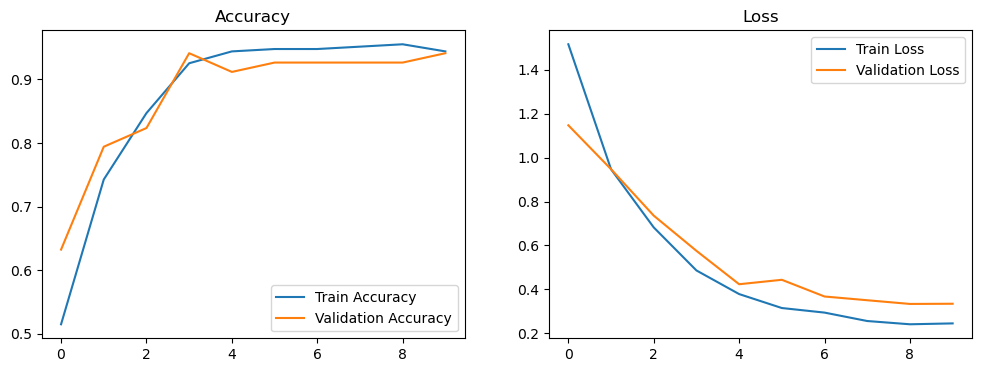

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step
              precision    recall  f1-score   support

          AS       0.97      1.00      0.99        36
          MR       0.97      0.94      0.96        36
          MS       0.94      0.94      0.94        36
           N       1.00      1.00      1.00        36

    accuracy                           0.97       144
   macro avg       0.97      0.97      0.97       144
weighted avg       0.97      0.97      0.97       144

Test Accuracy: 0.9722222222222222


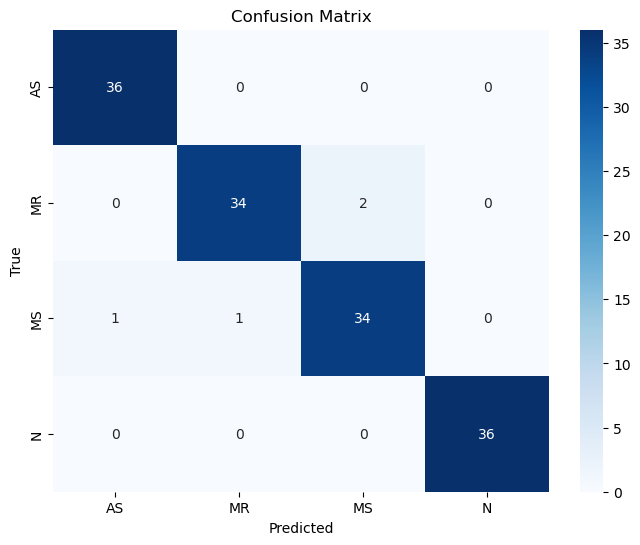

In [13]:
# Example to use only MFCC data.
input_shape = (X_train_mfcc.shape[1], 1)
num_classes = y_train_mfcc.shape[1]

model = IncrementalBiLSTM(input_shape, num_classes, l2_reg=0.0005)
model.train_initial(X_train_mfcc, np.argmax(y_train_mfcc, axis=1))
model.evaluate_model(X_test_mfcc, np.argmax(y_test_mfcc, axis=1), label_encoder)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)



['AS' 'MR' 'MS' 'N']
Epoch 1/10, Loss: 0.7557, Accuracy: 0.7562, Val_Loss: 0.3914, Val_Accuracy: 0.8696
Epoch 2/10, Loss: 0.4392, Accuracy: 0.9204, Val_Loss: 0.4373, Val_Accuracy: 0.9130
Epoch 3/10, Loss: 0.3716, Accuracy: 0.9303, Val_Loss: 0.3184, Val_Accuracy: 0.9565
Epoch 4/10, Loss: 0.3104, Accuracy: 0.9602, Val_Loss: 0.2462, Val_Accuracy: 0.9565
Epoch 5/10, Loss: 0.2803, Accuracy: 0.9652, Val_Loss: 0.2401, Val_Accuracy: 1.0000
Epoch 6/10, Loss: 0.2431, Accuracy: 0.9701, Val_Loss: 0.1844, Val_Accuracy: 1.0000
Epoch 7/10, Loss: 0.2178, Accuracy: 0.9701, Val_Loss: 0.1926, Val_Accuracy: 1.0000
Epoch 8/10, Loss: 0.1998, Accuracy: 0.9751, Val_Loss: 0.1667, Val_Accuracy: 1.0000
Epoch 9/10, Loss: 0.1850, Accuracy: 0.9801, Val_Loss: 0.1650, Val_Accuracy: 1.0000
Epoch 10/10, Loss: 0.1715, Accuracy: 0.9801, Val_Loss: 0.1512, Val_Accuracy: 1.0000


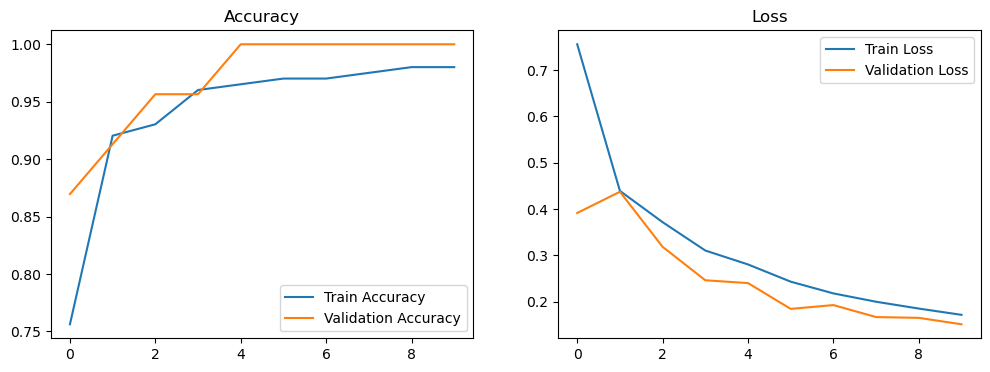

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
              precision    recall  f1-score   support

          AS       0.97      1.00      0.99        36
          MR       1.00      0.67      0.80        36
          MS       0.77      0.94      0.85        36
           N       0.92      1.00      0.96        36

    accuracy                           0.90       144
   macro avg       0.92      0.90      0.90       144
weighted avg       0.92      0.90      0.90       144

Test Accuracy: 0.9027777777777778


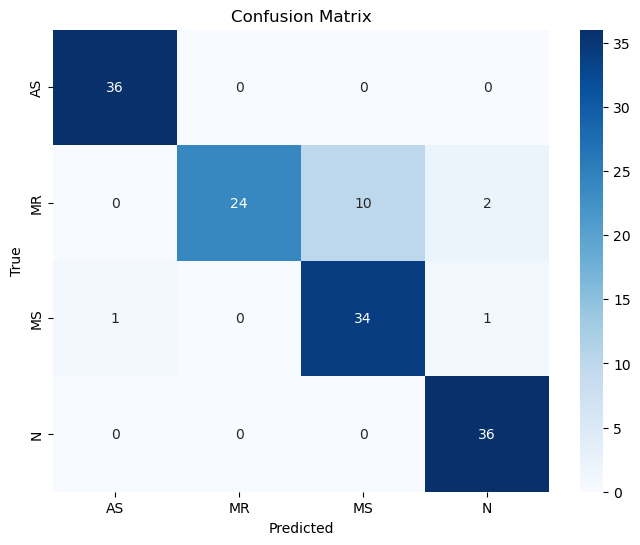

In [14]:
with open("label_encoder.pkl", "rb") as f:
    loaded_label_encoder = pickle.load(f)

incremental_csv_path = r"..\Dataset\inc_audio_mfcc_features_with_labels.csv"

inc_train_x_mfcc, inc_train_y_mfcc, inc_test_mfcc, _, _, _, _, _, upd_label_encoder, _ = SplitDataset(incremental_csv_path, loaded_label_encoder)
print(upd_label_encoder.classes_)
model.train_incremental(inc_train_x_mfcc, np.argmax(inc_train_y_mfcc, axis=1), validation_split=0.1) #use incremental train function.
model.evaluate_model(X_test_mfcc, np.argmax(y_test_mfcc, axis=1), upd_label_encoder)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(upd_label_encoder, f)

In [18]:
with open("label_encoder.pkl", "rb") as f:
    loaded_label_encoder = pickle.load(f)

mvp_csv_path = r"..\Dataset\continuous_audio_mfcc_features_with_labels.csv"
mvp_train_x_mfcc, mvp_train_y_mfcc, mvp_test_x_mfcc, mvp_test_y_mfcc, _, _, _, _, upd_label_encoder, _ = SplitDataset(mvp_csv_path, loaded_label_encoder)

_,_,old_x_test_mfcc, old_y_test_mfcc, _,_,_,_,upd_label_encoder, _ = SplitDataset(initial_csv_path, upd_label_encoder)
print(upd_label_encoder.__dict__)
model.add_new_label(mvp_train_x_mfcc, np.argmax(mvp_train_y_mfcc, axis=1)) #use incremental train function.

# Ensure all arrays are NumPy arrays
print(old_y_test_mfcc[12])
X_combined_test = np.concatenate((old_x_test_mfcc, mvp_test_x_mfcc), axis=0)
y_combined_test = np.concatenate((old_y_test_mfcc, mvp_test_y_mfcc), axis=0)

# Evaluate the model with the combined test set
model.evaluate_model(X_combined_test, np.argmax(y_combined_test, axis=1), upd_label_encoder)

# model.evaluate_model(mvp_test_x_mfcc, np.argmax(mvp_test_y_mfcc, axis=1), upd_label_encoder)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(upd_label_encoder, f)

Skipping SMOTE: Only one class detected in y_train_spectrogram.
Skipping SMOTE: Only one class detected in y_train_mfcc.
{'classes_': array(['AS', 'MR', 'MS', 'N', 'MVP'], dtype=object)}
🔵 Adding new label: Current num_classes = 7, Incrementing by 1.
✅ Old Weights Stored Successfully!
✅ Old Output Layer Weights Retrieved
Old Output Layer Weights Shape: [(256, 4), (4,)]
✅ Created New Output Layer with 8 Classes
🔄 Applying layer 0: input_layer_1 (InputLayer)
🚨 Error at layer 0: input_layer_1 - too many positional arguments
[1. 0. 0. 0.]


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 4 and the array at index 1 has size 5

In [ ]:
# model.evaluate_model(mvp_test_x_mfcc, np.argmax(mvp_test_y_mfcc, axis=1), upd_label_encoder)

# with open("label_encoder.pkl", "wb") as f:
#     pickle.dump(upd_label_encoder, f)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ValueError: Number of classes, 5, does not match size of target_names, 1. Try specifying the labels parameter